# Post-Hoc Hypothesis Testing for Feature Selection with Large Volumes of Data Notebook

## About 

## Requirements 

You will need to install the following Python packages to work with this notebook. 

* [Jupyter](https://jupyter.org/)
* [Numpy](http://www.numpy.org/) 
* [Scipy](http://www.scipy.org/) 
* [Matplotlib](http://matplotlib.org/)
* [Sklearn](http://scikit-learn.org/)
* [PyFeast](https://github.com/mutantturkey/PyFeast) 

If there is a package I missed then send an email to <ditzler@email.arizona.edu>.


# Imports

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris 
from sklearn.feature_selection import chi2 
from sklearn.feature_selection.univariate_selection import SelectFpr 
from scipy.stats import binom

from fse.feature_selection.ensemble import npfs_chi2
from fse.feature_selection.ensemble import npfs
from fse.feature_selection.ensemble import bootstrap_selection
from fse.feature_selection.single import chi2_selection
from fse.utils import syn_data

Populating the interactive namespace from numpy and matplotlib


# Iris Example with Noise 

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
v = np.zeros((4,))

pval, sels = chi2_selection(1.0*X, y, 2)
v[sels] = 1.

print "Fisher Iris Experiment"
print "pval:", pval
print "sels:", sels
print "v:", v

X2 = np.concatenate((X, np.random.rand(150,20)*20), axis =1)
s,b,d = npfs_chi2(X2, y, fpr=0.001, alpha=0.05, n_bootstraps=50)
print len(s), len(X2[1])

Fisher Iris Experiment
pval: [  4.47651499e-03   1.65754167e-01   5.94344354e-26   2.50017968e-15]
sels: [2 3]
v: [ 0.  0.  1.  1.]
22 24


# Synthetic Data

## Single Experiement 
This is only to see if the code is working. 

In [3]:
n_features = 25
n_observations = 100
n_relevant = 5

data, labels = syn_data(n_features = 25, n_observations = 100, n_relevant = 5)

s,b,d = npfs_chi2(data, labels, fpr=0.01, alpha=0.01, n_bootstraps=50)
k = bootstrap_selection(b.sum(axis=1), 100, normalizer="poly", poly=0)

print binom.ppf(1 - .01, 50, 0.01)
print len(s), s
print len(b.sum(axis=1)), b.sum(axis=1)
print "Set size:", k

3.0
22 [0, 1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
25 [ 35.  27.  48.  50.  50.   1.  12.   3.   9.   3.   4.  15.  23.  19.   7.
   6.   7.   4.   6.  21.   4.   4.  11.   8.  10.]
Set size: 15.86


## Effect of the polynomial

In this experiment we measure the effect that the polynomial has on the ability of the bootstrap procedure to detect if a feature is relevant. The polynomial scaling proceedure is implemented as follows. After running NPFS, the Bernoulli R.V.s are normalized to 1 ($p(i)$ for $i \in [K]$) then the effective probability is raised to the $x^{\textrm{th}}$ power. That is

$$
p_{new} (i) = \frac{1}{Z} p^x(i)
$$

where $x \geq 0$. We then vary $x$ in the range $[0,5]$ and measure the feature set size that is returned. Clearly as $x$ becomes greater the smaller probabilities will vanish, which will result in fewer features being selected. 


In [15]:
n_averages = 25
n_features = 25
n_observations = 100
n_relevant = 5
polies = [1.*x/10 for x in range(60)]
set_sizes = np.zeros((len(polies),))
no_correction = 0

for pn in range(len(polies)):
    poly = polies[pn]
    for na in range(n_averages):
        data, labels = syn_data(n_features = 25, n_observations = 100, n_relevant = 5)
        sel, binm, delta = npfs_chi2(data, labels, fpr=0.01, alpha=0.01, n_bootstraps=50)
        set_sizes[pn] += bootstrap_selection(b.sum(axis=1), 100, normalizer="poly", poly=poly)
        no_correction += bootstrap_selection(b.sum(axis=1), 100, normalizer="minmax")

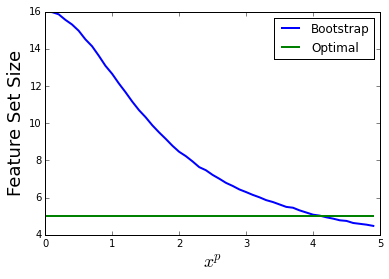

In [7]:
# plot the results from above
axis_font = {'size':'18'}
plt.plot(polies, set_sizes/n_averages, label='Bootstrap', lw=2)
plt.plot(polies, np.ones((len(polies),))*n_relevant, label='Optimal', lw=2)
plt.plot(polies, np.ones((len(polies),))*no_correction/(pn*n_averages), label='MinMax', lw=2)

plt.xlabel('$x^p$', **axis_font)
plt.ylabel('Feature Set Size', **axis_font)
plt.legend()
plt.savefig('npfs_feature_size_poly.pdf', bbox_inches='tight')
plt.show()

# NPFS Original Selections

This section of the notebook contains an experiment to examine the Bernoulli matrix in NPFS. Recall that NPFS builds up a matrix of Bernoulli R.V.s and recall that we claim if we examine the sum of the rows scaled by the number of bootstraps that we obtain (approximately) $p_0 = k/K$. We show that this is indeed the case, though we could craft up other possibility for how to view the random variable.

In this experiment, we set $k = 25$, $K=100$, $k^*=5$, and $N=500$. We examine the histgram of $\hat{p}_0$ for each of the features and we do in fact see that $\mathbb{E}[\hat{p}_0] \approx k/K$.

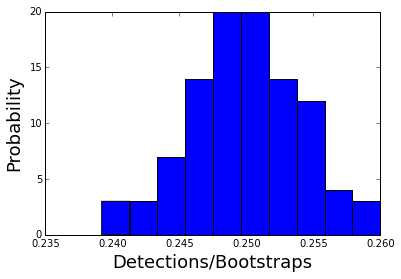

Expected Value: 0.25


In [13]:
n_boots = 100
n_feats = 100
n_relev = 5
n_selec = 25
n_averages = 100
axis_font = {'size':'18'}
binz = 10
bino_vec = np.zeros((n_feats,))

for na in range(n_averages):
    bino_mat = np.zeros([n_feats, n_boots])
    for n in range(n_boots):
        x = np.random.permutation(n_feats)
        x = x[:n_selec]
        bino_mat[x[:n_selec], n] = 1.
    bino_vec += bino_mat.sum(axis=1)/n_boots

bino_vec /= n_averages
n, bins, patches = plt.hist(bino_vec, binz)
plt.xlabel('Detections/Bootstraps', **axis_font)
plt.ylabel('Probability', **axis_font)
plt.savefig('npfs_detections.pdf', bbox_inches='tight')
plt.show()

print "Expected Value:", bino_vec.mean()